In [103]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## dataset qc

In [65]:
ndv = pd.read_csv("~/ndv_dino4cells_analysis/exploratory_configs/external_hpa_fov_cleaned.csv")
# ndv = pd.read_csv("~/ndv_dino4cells_analysis/exploratory_configs/1d_hpa_fov.csv")

In [48]:
master = pd.read_csv("/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/Master_fovHPA_512.csv")

In [140]:
master_files = os.listdir("/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/512_whole_images/")

In [148]:
master_file_ids = pd.Series(master_files).str.split(".").str[0]

In [151]:
master = master_file_ids[~master_file_ids.isin(master['ID'])]

In [157]:
master["ID"].isin(master_file_ids).all()

True

In [176]:
master_file_ids[~master_file_ids.isin(master["ID"])]

20417    25807_666_C11_1
20418    25807_666_C11_2
20419    25807_669_C11_2
20420    25807_669_C11_3
20422    25807_671_C11_2
21979     27093_230_D1_1
21980     27093_230_D1_2
21981     27093_231_D1_1
21982     27093_231_D1_2
21983     27093_232_D1_1
21984     27093_232_D1_2
29118    30871_371_D10_1
29119    30871_371_D10_2
29120    30871_372_D10_1
29121    30871_372_D10_2
29122    30871_374_D10_1
29123    30871_374_D10_2
33304    35134_1396_F8_1
33305    35134_1396_F8_4
93347    76521_1802_F6_2
93349    76521_1833_E2_1
93350    76521_1833_E2_2
dtype: object

In [63]:
# check master
ids = master['Path'].str.split("/").str[-1].str.split(".").str[0].values
assert (ids == master["ID"]).all()

ids = master['prev_Path'].str.split("/").str[-1].str.split(".").str[0].values
master.loc[(ids != master['ID'].values)][["ID", "Path", "prev_Path"]]

,ID,Path,prev_Path
64,43995_1977_B5_37_cr5e5687d60d6f8,whole_images/512_whole_images/43995_1977_B5_37...,HPA_FOV/512_whole_images/43995_1977_B5_37.tiff
65,43995_1977_B5_53_cr5e5687d60dd8e,whole_images/512_whole_images/43995_1977_B5_53...,HPA_FOV/512_whole_images/43995_1977_B5_53.tiff
104,51928_1650_B2_43_cr57ea9a8572196,whole_images/512_whole_images/51928_1650_B2_43...,HPA_FOV/512_whole_images/51928_1650_B2_43.tiff
105,51928_1650_B2_58_cr57ea9a8d579b7,whole_images/512_whole_images/51928_1650_B2_58...,HPA_FOV/512_whole_images/51928_1650_B2_58.tiff
158,78608_1869_G3_32_cr5b7539ef42483,whole_images/512_whole_images/78608_1869_G3_32...,HPA_FOV/512_whole_images/78608_1869_G3_32.tiff
...,...,...,...
82260,72650_1650_E6_48_cr57eb8f024da01,whole_images/512_whole_images/72650_1650_E6_48...,HPA_FOV/512_whole_images/72650_1650_E6_48.tiff
82359,10089_1878_D10_40_cr5b7d732830784,whole_images/512_whole_images/10089_1878_D10_4...,HPA_FOV/512_whole_images/10089_1878_D10_40.tiff
82360,10089_1878_D10_48_cr5b7d732830cd9,whole_images/512_whole_images/10089_1878_D10_4...,HPA_FOV/512_whole_images/10089_1878_D10_48.tiff
82381,68942_1637_E12_7_cr57a1c621a1d2c,whole_images/512_whole_images/68942_1637_E12_7...,HPA_FOV/512_whole_images/68942_1637_E12_7.tiff


In [77]:
ndv['file'] = ndv['file'].str.split("/").str[-1]

In [69]:
ndv["ID"] = ndv['file'].str.split("/").str[-1].str.split(".").str[0]

In [99]:
# pd.merge(master, ndv["ID"], on="ID", how="right")
missing = ndv[~ndv["ID"].isin(master["ID"])]

# due to extended IDs for some files in master, gotta do partial match search:
out = [master['ID'].str.contains(i).any() for i in missing['ID']]
out = [not o for o in out]

In [101]:
really_missing = missing.loc[out]
really_missing.shape
# 24 images present in the zenodo file (and derivatives) are missing from master - not worth bothering probably

(24, 2)

### generate 1d training csv for individual pngs

In [192]:
files = os.listdir("/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/512_whole_images_split/")
files = np.array(files)
ids = pd.Series(files).str.split(".").str[0].str.split("_channel").str[0]
fovHPA_1d = pd.DataFrame(np.stack([files, ids]).T, columns=["file", "ID"])

In [193]:
# 22 downloaded images have unknown labels 
# they are excluded from master (and other training csvs) for simplicity
fovHPA_1d = fovHPA_1d[fovHPA_1d["ID"].isin(master["ID"])]
assert (np.array(sorted(fovHPA_1d['ID'].unique())) == np.array(sorted(master['ID'].unique()))).all()

In [194]:
fovHPA_1d["file"] = "whole_images/512_whole_images_split/" + fovHPA_1d["file"].astype(str)

In [196]:
fovHPA_1d.to_csv("/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/fovHPA_1d_512.csv", index=False)

In [195]:
fovHPA_1d

,file,ID
0,whole_images/512_whole_images_split/00070df0-b...,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
1,whole_images/512_whole_images_split/00070df0-b...,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
2,whole_images/512_whole_images_split/00070df0-b...,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
3,whole_images/512_whole_images_split/00070df0-b...,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
4,whole_images/512_whole_images_split/000a6c98-b...,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
...,...,...
454263,whole_images/512_whole_images_split/fffdf7e0-b...,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0
454264,whole_images/512_whole_images_split/fffe0ffe-b...,fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0
454265,whole_images/512_whole_images_split/fffe0ffe-b...,fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0
454266,whole_images/512_whole_images_split/fffe0ffe-b...,fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0


In [198]:
fovHPA_1d['file'].str.contains("8f50425a-bbb5-11e8-b2ba-ac1f6b6435d0_channel_0.png").any()

True

In [199]:
!ls "/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/512_whole_images_split/8f50425a-bbb5-11e8-b2ba-ac1f6b6435d0_channel_0.png"

/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/512_whole_images_split/8f50425a-bbb5-11e8-b2ba-ac1f6b6435d0_channel_0.png


### generate csv for 1d training using tiff stacks with n_channels x each entry
Sampling a single channel for each item from master during 1d training would mean only ~1/4 of all channels are included in each epoch. We can avoid this by duplicating records in the csv by the number of channels. Over sufficiently many epochs this should be roughly equal to a strict sampling of each channel per image per epoch (whereas simply increasing the number of iterations per epoch with resampling would not). 

In [202]:
master_4x = pd.concat([master, master, master, master])

In [206]:
master_4x.to_csv("/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/Master_fovHPA_512_1d.csv", index=False)

## explore images

In [23]:
ims = []
for i in range(4):
    ims.append(io.imread(f"/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/512_whole_images_split/31730_571_A7_1_channel_{i}.png"))

ims = np.stack(ims)

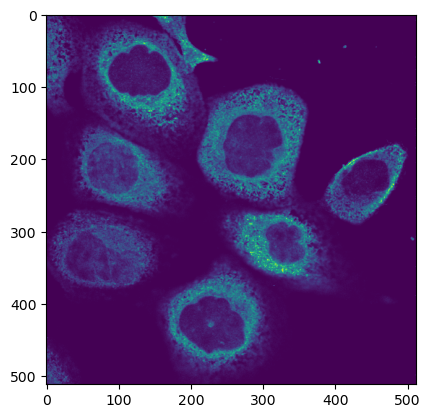

In [29]:
plt.imshow(ims[3])

(512, 512, 4)